In [1]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
#%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [2]:
dataset_path="/Users/joesh/Documents/transformers/data"
checkpoint_path="/Users/joesh/Documents/transformers/data"

In [3]:
device=torch.device("cpu") if not torch.backends.mps.is_available() else torch.device("mps")
device

device(type='mps')

In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(checkpoint_path, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
#for file_name in pretrained_files:
 #   file_path = os.path.join(checkpoint_path, file_name)
#    if not os.path.isfile(file_path):
#        file_url = base_url + file_name
#        print(f"Downloading {file_url}...")
#        try:
 #           urllib.request.urlretrieve(file_url, file_path)
 #       except HTTPError as e:
 #           print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [5]:
#Start by defining a base class for activation functions which future modules will inherit
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}
        

In [6]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1/(1+torch.exp(-x))

In [7]:
class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp=torch.exp(x), torch.exp(-x)
        return (x_exp-neg_x_exp)/(x_exp+neg_x_exp)

In [8]:
#another popular activation function is the relu functioon. Despite its simplicity of being a piecewise
#linear function, it has one major benefit -> a strong stable graident for large range of values
#three tpes leakyReLU, ELU and Swish. LeakyReLU replaces zero settings in the negative part with smaller scope
#to allow gradients to flow also in this part of the input. Elu replaces negative part with exponential decay
#swish is both smooth and non-monotonic/ 

class ReLU(ActivationFunction):
    def forward(self, x):
        return x*(x>0).float()

In [9]:
class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"]=alpha
    
    def forward(self, x):
        return torch.where(x>0, x, self.config["alpha"]*x)
        

In [10]:
class Elu(ActivationFunction):
    def forward(self, x):
        return torch.where(x>0, x, torch.exp(x)-1)

In [11]:
class Swish(ActivationFunction):
    
    def forward(self, x):
        return x*torch.sigmoid(x)

In [12]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": Elu,
    "swish": Swish
}

In [13]:
def get_grads(act_fn, x):
    """
    computes the gradients of activation function at specified positions
    
    Inputs:
          act_fn - An object of the class "Activation function" with an implemented forward pass
          x-10 input tensor
    Output:
           A tensor with the same size of x containing the gradients of act_fn at x
    """
    x=x.clone().requires_grad_() #mark the input as tensor for which we want to store gradients
    out=act_fn(x)
    out.sum().backward() #summing the results in an equal gradient flow to each element in x
    return x.grad

In [14]:
input_size=784
hidden_sizes=[512,256,256,128]
[input_size]+hidden_sizes

[784, 512, 256, 256, 128]

In [15]:
#Lets set up a neural network. The chosen network views images as 1D tensors and pushes them through a sequence of
#linear layers and a specified activation fucntion

class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512,256,256,128]):
        """
        Inputs:
               act_fn= Object of the activation function that should be used as non-linearity in the network
               input_size - size of input images in pixes 
               num_classes - number of classes we want to predict
               hidden_sizes - a list of integers specifying the hidden layer sizes in the nn
        """
        super().__init__()
        
        #Create the network based on the specified hidden sizes
        layers=[]
        layer_sizes=[input_size]+hidden_sizes
        for layer_index in range(1,len(layer_sizes)):
            layers+=[nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers=nn.Sequential(*layers)  #nn.sequential summarises a list of modules into a single module, applying in sequence
    
        # We store all the hyperparameters in a dictionary for saving and loading of the model
        self.config={"act_fn":act_fn.config, "input_size":input_size, 
                 "num_classes":num_classes, "hidden_sizes":hidden_sizes}
    
    def forward(self, x):
        x=x.view(x.size(0), -1) #Reshape images to a flat vector
        out=self.layers(x)
        return out

In [16]:
def attempt_load(weights, device=None, inplace=True, fuse=True):
     # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
     from models.yolo import Detect, Model

     # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
     model = Ensemble()
     for w in weights if isinstance(weights, list) else [weights]:
         ckpt = torch.load(attempt_download(w), map_location=device)
         ckpt = (ckpt.get('ema') or ckpt['model']).float()  # FP32 model
         ckpt = torch.load(attempt_download(w), map_location='cpu')  # load
         ckpt = (ckpt.get('ema') or ckpt['model']).to(device).float()  # FP32 model
         model.append(ckpt.fuse().eval() if fuse else ckpt.eval())

In [17]:
hi={"act_fn": {"name": "ReLU"}, "input_size": 784, "num_classes": 10, "hidden_sizes": [512, 256, 256, 128]}

output=hi["act_fn"].pop('name').lower()
act_f=act_fn_by_name[output](**hi.pop("act_fn"))
act_f

ReLU()

In [18]:
#Also add functions for laoding and saving the model

def _get_config_file(model_path, model_name):
    #Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name+ ".config")

def _get_model_file(model_path, model_name):
    #Name of the file for storing network parameters
    return os.path.join(model_path, model_name+".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk
    
    Inputs:
           model_path- path of the checkpoint directory
           model_name - name of the model
           net- if given, the state dict is loaded into this model, Otherwise a new model is created
    """
    
    config_file, model_file= _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name=config_dict["act_fn"].pop("name").lower() #returns name of model and remove act from config dict
        act_fn=act_fn_by_name[act_fn_name](**config_dict.pop("act_fn")) #returns config dict list of hyperparameters pop extracts act func we want
        net=BaseNetwork(act_fn=act_fn, **config_dict)  
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)
        

In [19]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

#Transformeation applied to each image -> first make a tensor than normalise in range -1,1
transform=transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))])  #mean and std parameters passed in as 0.5, 0.5
#
train_dataset=FashionMNIST(root=dataset_path, train =True, transform=transform, download=True)
train_set, val_set=torch.utils.data.random_split(train_dataset, [50000, 10000])

#load test
test_set=FashionMNIST(root=dataset_path, train=False, transform=transform, download=True)

#We define a set of data loaders we can use for various purposes later

train_loader=data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader=data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader=data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [20]:
train_dataset[0][0] #first image
train_dataset[0][1] #first label


9

In [21]:
train_dataset.__getitem__(4)
#train_dataset.__len__()

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -0.7961, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000,  0.4824,  0.6157,  0.4667, -0.7490, -1.0000, -1.0000,
           -1.0000, -0.7961,  0.7020,  0.7725,  0.5373, -0.9137, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000,  0.5059,  0.7804,  0.8353,  0.9059,  0.8039,  0.1529,
            0.8745,  0.8980,  0.8353,  0.7098,  0.6392, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000,  0.3569,  0.764

In [22]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(checkpoint_path, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, checkpoint_path, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(checkpoint_path, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [23]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation ...")
    torch.seed()
    act_fn=act_fn_by_name[act_fn_name]()
    net_actfn=BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation ...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation ...
Model file already exists. Skipping training...
============= Test accuracy: 88.49% ==============

Training BaseNetwork with relu activation ...
Model file already exists. Skipping training...
============= Test accuracy: 88.64% ==============

Training BaseNetwork with leakyrelu activation ...
Model file already exists. Skipping training...
============= Test accuracy: 89.32% ==============

Training BaseNetwork with elu activation ...
Model file already exists. Skipping training...
============= Test accuracy: 87.80% ==============

Training BaseNetwork with swish activation ...
Model file already exists. Skipping training...
============= Test accuracy: 88.55% ==============



In [24]:
import pickle


#with open('/Users/joesh/Documents/transformers/data/archive/data.pkl', 'rb') as f:
    #data = pickle.load(f)

In [25]:
#data['layers.0.weight'].shape

In [26]:
#Although model is trained we can look at the activation values within the model
#For example how many neuros are set to zero within the model

def visualize_activations(net, color='C0'):
    
    activations={}
    small_loader=data.DataLoader(train_set, batch_size=1024)
    imgs, labels= next(iter(small_loader))
    with torch.no_grad():
        layer_index=0
        imgs=imgs.to(device)
        imgs=imgs.view(imgs.size(0),-1)
        
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs=layer(imgs)
            activations[layer_index]=imgs.view(-1).cpu().numpy()
            
    #plotting
    columns=4
    rows=math.ceil(len(activations)/columns)
    
    fig, ax=plt.subplots(rows,columns, figsize=(columns*2.7, rows*2.7))
    fig_index=0
    
    for key in activations:
        key_ax=ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

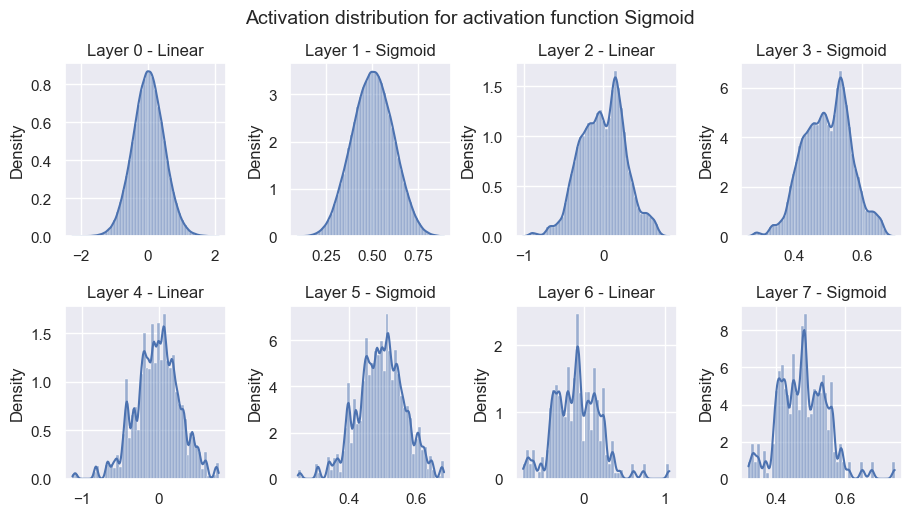

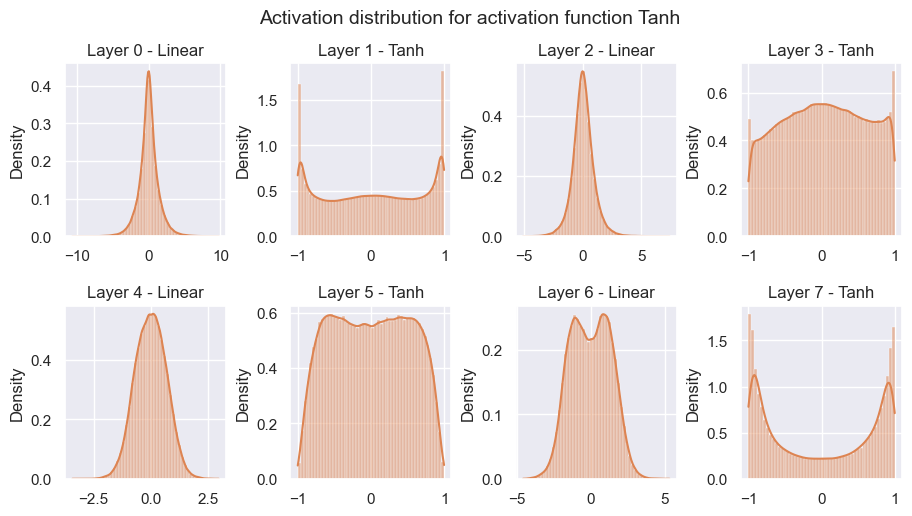

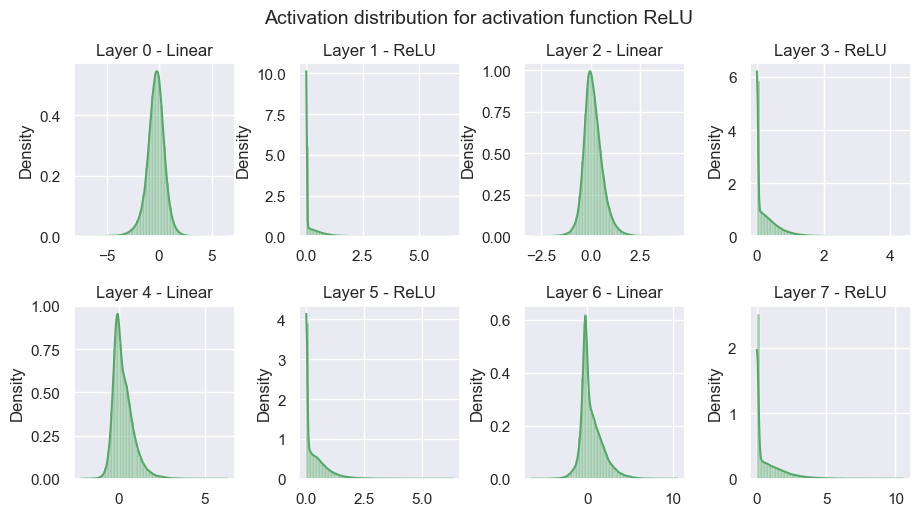

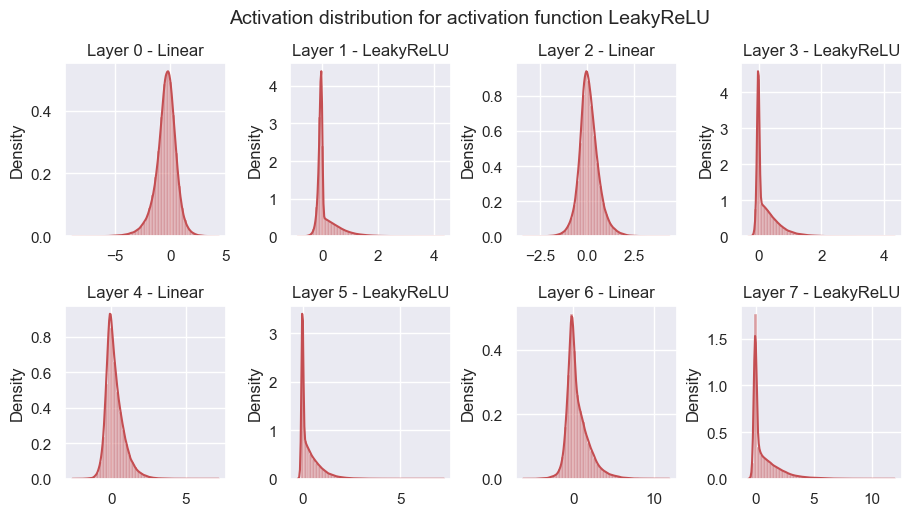

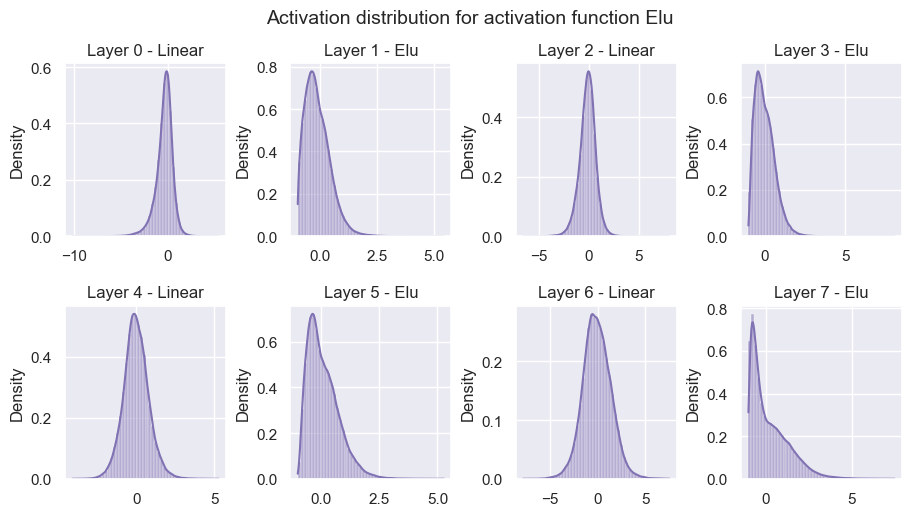

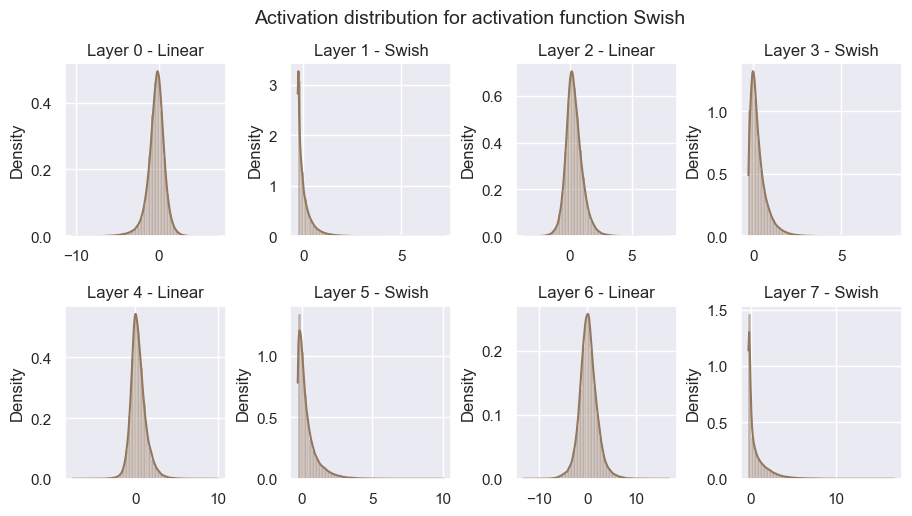

In [27]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn=load_model(model_path=checkpoint_path, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")